
## TRAINING SAGEBoost for Node-Level Prediction ##
---



In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Amazon
from torch_geometric.loader import NeighborSampler


In [3]:
path = os.path.join("..", "tmp", "data", "Amazon")
show_dataset = Amazon(path, "Computers")
show_data = show_dataset[0]

# Print information about the dataset
print(f'Number of nodes: {show_dataset[0].x.shape[0]}')
print(f'Number of features: {show_dataset.num_features}')
print(f'Number of edge features: {show_dataset.num_edge_features}')
print(f'Number of node features: {show_dataset.num_node_features}')
print(f'Number of classes: {show_dataset.num_classes}')
print(f'Has isolated nodes: {show_dataset[0].has_isolated_nodes()}')

Processing...


Number of nodes: 13752
Number of features: 767
Number of edge features: 0
Number of node features: 767
Number of classes: 10
Has isolated nodes: True


Done!


In [4]:
path = os.path.join("..", "tmp", "data", "Amazon")
show_dataset = Amazon(path, "Photo")
show_data = show_dataset[0]

# Print information about the dataset
print(f'Number of nodes: {show_dataset[0].x.shape[0]}')
print(f'Number of features: {show_dataset.num_features}')
print(f'Number of edge features: {show_dataset.get_summary}')
print(f'Number of node features: {show_dataset.num_node_features}')
print(f'Number of classes: {show_dataset.num_classes}')
print(f'Has isolated nodes: {show_dataset[0].has_isolated_nodes()}')

Processing...
Done!


Number of nodes: 7650
Number of features: 745
Number of edge features: <bound method Dataset.get_summary of AmazonPhoto()>
Number of node features: 745
Number of classes: 8
Has isolated nodes: True


<BarContainer object of 248 artists>

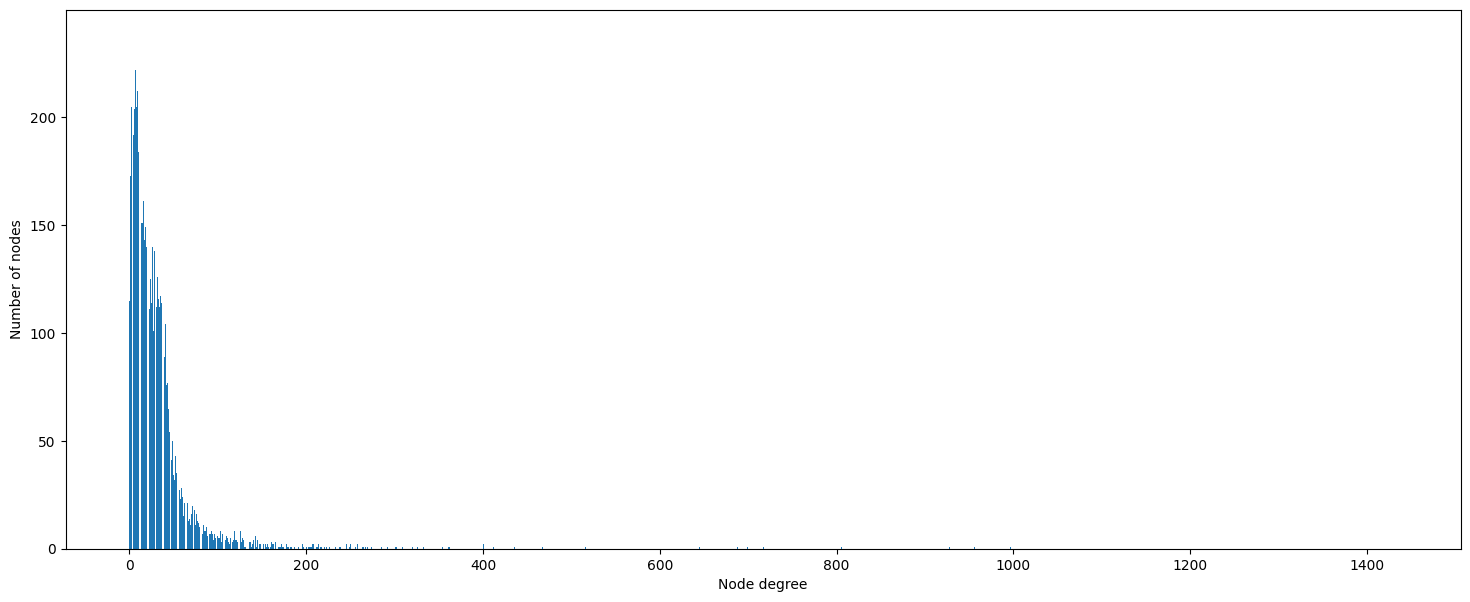

In [5]:
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Get list of degrees for each node
degrees = degree(show_data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.title("")
plt.bar(numbers.keys(),
        numbers.values())

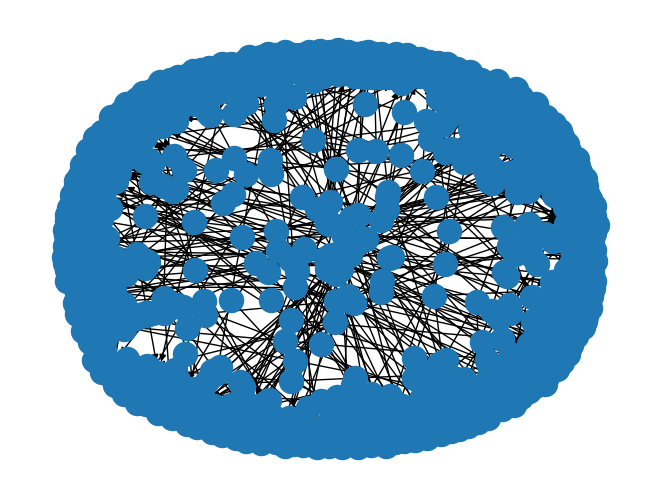

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

plot_data = show_data
plot_data.x.resize_(1000,602)
plot_data.edge_index.resize_(2,10000)
plot_data.y.resize_(1000)

g = to_networkx(plot_data)
nx.draw(g)

In [6]:
from torch_geometric.nn import SAGEConv
from typing import List, Optional, Tuple
from tqdm import tqdm
from torch_geometric.loader.neighbor_sampler import EdgeIndex

class SAGEBoost(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels1: int, out_channels: int) -> None:
        super().__init__()

        self.num_layers = 2
        self.convs = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_channels1))
        self.convs.append(SAGEConv(hidden_channels1, out_channels))

    def forward(self, x: torch.Tensor, adjs: List[EdgeIndex]) -> torch.Tensor:
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[: size[1]]
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.leaky_relu(x)

                # use leaky relu in order to prevent dying (zero-ed negative neurons issue)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all: torch.Tensor, subgraph_loader: NeighborSampler) -> torch.Tensor:
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description("Evaluating")


        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[: size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.leaky_relu(x)
                    # use leaky relu in order to prevent dying (zero-ed negative neurons issue)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


In [7]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        x: torch.Tensor,
        y: torch.Tensor,
        train_mask: torch.Tensor,
        val_mask: torch.Tensor,
        test_mask: torch.Tensor,
        optimizer: torch.optim.Optimizer,
        sizes: List[int] = [25, 10],
        batch_size: int = 512,
        num_workers: int = 2,
    ) -> None:
        self.model = model
        self.data = data
        self.x = x
        self.y = y
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask
        self.optimizer = optimizer
        self.train_loader = NeighborSampler(
            data.edge_index,
            node_idx=data.train_mask,
            sizes=sizes,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        self.subgraph_loader = NeighborSampler(
            data.edge_index, node_idx=None, sizes=[-1], batch_size=batch_size, shuffle=False, num_workers=num_workers
        )
    def training_epoch(self, epoch: int) -> float:
      self.model.train()
      pbar = tqdm(total=int(self.train_mask.sum()))
      pbar.set_description(f"Epoch {epoch:02d}")
      total_loss = 0
      for batch_size, n_id, adjs in self.train_loader:
          # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
          adjs = [adj.to(device) for adj in adjs]
          self.optimizer.zero_grad()
          out = self.model(self.x[n_id], adjs)
          loss = F.nll_loss(out, self.y[n_id[:batch_size]])
          loss.backward()
          self.optimizer.step()
          total_loss += float(loss)
          pbar.update(batch_size)

      pbar.close()
      loss = total_loss / len(self.train_loader)
      return loss

    @torch.no_grad()
    def evaluate(self) -> List[float]:
        self.model.eval()

        out = self.model.inference(self.x, self.subgraph_loader)
        print(out)
        print(out.shape)
        y_true = self.y.cpu().unsqueeze(-1)
        print(y_true)
        print(y_true.shape)
        y_pred = out.argmax(dim=-1, keepdim=True)

        results = []
        for mask in [self.train_mask, self.val_mask, self.test_mask]:
            results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

        return results

    def fit(self, num_epochs: int = 10):
      train_curve = []
      test_curve = []
      validation_curve = []
      for epoch in range(1, num_epochs + 1):
          loss = self.training_epoch(epoch)

          writer = SummaryWriter('runs/MAI_114M_AI_CP_test')
          writer.add_scalar('Loss', loss, epoch)

          print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")
          train_acc, val_acc, test_acc = self.evaluate()
          train_curve.append(loss)
          test_curve.append(test_acc)
          validation_curve.append(val_acc)
          print(f"Train: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")
      return train_curve, test_curve, validation_curve



%load_ext tensorboard
class Trainer2:
    def __init__(
        self,
        model: torch.nn.Module,
        x: torch.Tensor,
        y: torch.Tensor,
        train_mask: torch.Tensor,
        val_mask: torch.Tensor,
        test_mask: torch.Tensor,
        optimizer: torch.optim.Optimizer,
        sizes: List[int] = [25, 10],
        batch_size: int = 512,
        num_workers: int = 2,
    ) -> None:
        self.model = model
        self.data = data2
        self.x = x
        self.y = y
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask
        self.optimizer = optimizer
        self.train_loader = NeighborSampler(
            data2.edge_index,
            node_idx=data2.train_mask,
            sizes=sizes,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        self.subgraph_loader = NeighborSampler(
            data2.edge_index, node_idx=None, sizes=[-1], batch_size=batch_size, shuffle=False, num_workers=num_workers
        )
    def training_epoch(self, epoch: int) -> float:
      self.model.train()
      pbar = tqdm(total=int(self.train_mask.sum()))
      pbar.set_description(f"Epoch {epoch:02d}")
      total_loss = 0
      for batch_size, n_id, adjs in self.train_loader:
          # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
          adjs = [adj.to(device) for adj in adjs]
          self.optimizer.zero_grad()
          out = self.model(self.x[n_id], adjs)
          loss = F.nll_loss(out, self.y[n_id[:batch_size]])
          loss.backward()
          self.optimizer.step()
          total_loss += float(loss)
          pbar.update(batch_size)

      pbar.close()
      loss = total_loss / len(self.train_loader)
      return loss

    @torch.no_grad()
    def evaluate(self) -> List[float]:
        self.model.eval()

        out = self.model.inference(self.x, self.subgraph_loader)
        print(out)
        print(out.shape)
        y_true = self.y.cpu().unsqueeze(-1)
        print(y_true)
        print(y_true.shape)
        y_pred = out.argmax(dim=-1, keepdim=True)

        results = []
        for mask in [self.train_mask, self.val_mask, self.test_mask]:
            results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

        return results

    def fit(self, num_epochs: int = 10):
      train_curve = []
      test_curve = []
      validation_curve = []
      for epoch in range(1, num_epochs + 1):
          loss = self.training_epoch(epoch)

          writer = SummaryWriter('runs/MAI_114M_AI_CP_test')
          writer.add_scalar('Loss', loss, epoch)

          print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")
          train_acc, val_acc, test_acc = self.evaluate()
          train_curve.append(loss)
          test_curve.append(test_acc)
          validation_curve.append(val_acc)
          print(f"Train: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")
      return train_curve, test_curve, validation_curve

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import torch.nn.functional as F

path = os.path.join("..", "tmp", "data", "Amazon")
dataset1 = Amazon(path, "Computers")
data = dataset1[0]
data.train_mask = data.val_mask = data.test_mask = None
rns = RandomNodeSplit()
data = rns(data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAGEBoost(dataset1.num_features, 256, dataset1.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model.to(device),
    x=data.x.to(device),
    y=data.y.squeeze().to(device),
    train_mask=data.train_mask,
    val_mask=data.val_mask,
    test_mask=data.test_mask,
    optimizer=optimizer,
)


In [9]:
train_curve, test_curve, val_curve = trainer.fit(num_epochs=20)

torch.cuda.empty_cache()

Epoch 01: 100%|██████████| 12252/12252 [00:10<00:00, 1159.99it/s]


Epoch 01, Loss: 4.0451


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 9570.89it/s] 


tensor([[-4.9593, -0.4593, -3.6738,  ..., -3.9186, -2.0403, -4.3429],
        [-3.3551, -1.4844, -2.7436,  ..., -5.3373, -2.8200, -5.0806],
        [-3.2040, -0.9131, -2.5809,  ..., -2.1084, -0.6413, -3.0526],
        ...,
        [-5.9161, -1.7960, -4.4311,  ..., -2.8537, -1.4174, -4.8911],
        [-3.1272, -0.7878, -2.3526,  ..., -4.3841, -1.6469, -4.2616],
        [-1.5720, -2.1479, -0.0265,  ..., -2.1560, -2.7361, -3.6443]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 4.0451, Val: 0.6580, Test: 0.6600


Epoch 02: 100%|██████████| 12252/12252 [00:10<00:00, 1193.40it/s]


Epoch 02, Loss: 0.7857


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10734.58it/s]


tensor([[ -4.5130,  -1.0062,  -6.4644,  ...,  -8.6306,  -2.4994,  -6.6210],
        [ -1.8336,  -1.8471,  -5.4542,  ..., -12.0413,  -3.5090,  -9.0719],
        [ -6.1212,  -2.1842,  -6.6850,  ...,  -5.2006,   1.4925,  -2.8938],
        ...,
        [-11.7980,  -3.8778,  -9.9818,  ...,  -5.3438,   1.8131,  -3.9051],
        [ -2.4097,  -0.7005,  -5.9656,  ..., -10.8302,  -0.8984,  -8.0228],
        [  0.1311,  -2.6332,   0.4370,  ...,  -4.1217,  -4.1949,  -7.5156]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.7857, Val: 0.8280, Test: 0.8170


Epoch 03: 100%|██████████| 12252/12252 [00:10<00:00, 1122.93it/s]


Epoch 03, Loss: 0.5536


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10422.60it/s]


tensor([[ -3.2375,  -0.8266,  -7.1217,  ...,  -9.2049,  -2.8457,  -5.6628],
        [ -0.6874,  -1.4021,  -6.2147,  ..., -13.7746,  -2.6841,  -8.1930],
        [ -4.5267,  -0.9515,  -7.8900,  ...,  -6.5130,   1.0930,  -2.3854],
        ...,
        [ -8.9808,  -2.7792, -11.6910,  ...,  -5.7727,   1.1070,  -1.9996],
        [ -1.1786,  -0.0392,  -6.7603,  ..., -12.6728,  -0.5852,  -8.2181],
        [  1.4055,  -1.8819,  -0.5631,  ...,  -4.9368,  -3.9685,  -7.4719]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.5536, Val: 0.8620, Test: 0.8820


Epoch 04: 100%|██████████| 12252/12252 [00:10<00:00, 1140.48it/s]


Epoch 04, Loss: 0.4761


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10398.66it/s]


tensor([[ -3.9945,  -0.6273,  -7.6842,  ..., -10.1571,  -1.6951,  -7.9736],
        [ -3.4882,  -0.9267,  -8.6655,  ..., -14.3819,  -2.1915, -10.3699],
        [ -4.0679,  -1.3200,  -7.2963,  ...,  -6.4465,   1.2329,  -3.7380],
        ...,
        [ -7.4146,  -3.2159,  -8.5939,  ...,  -4.9776,   0.4040,  -5.7787],
        [ -2.9303,   0.2523,  -8.4579,  ..., -13.4120,   0.1134,  -9.8607],
        [  0.4974,  -1.9884,  -1.4763,  ...,  -4.8826,  -3.0737,  -8.3906]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.4761, Val: 0.8800, Test: 0.8900


Epoch 05: 100%|██████████| 12252/12252 [00:10<00:00, 1127.44it/s]


Epoch 05, Loss: 0.4374


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10427.93it/s]


tensor([[ -3.8945,  -0.7765,  -7.9081,  ..., -10.5576,  -1.5210,  -6.4121],
        [ -1.7918,  -1.3884,  -7.6523,  ..., -14.8225,  -1.6838,  -8.3482],
        [ -4.2269,  -0.9051,  -7.7833,  ...,  -7.4360,   1.3565,  -3.1452],
        ...,
        [ -7.5774,  -2.9338,  -9.5866,  ...,  -7.0330,   0.9409,  -3.2299],
        [ -2.2685,  -0.0302,  -8.0540,  ..., -13.4892,   0.2872,  -8.5701],
        [  1.0698,  -1.3195,  -1.6432,  ...,  -6.6566,  -2.7437,  -9.2076]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.4374, Val: 0.8940, Test: 0.9030


Epoch 06: 100%|██████████| 12252/12252 [00:10<00:00, 1117.47it/s]


Epoch 06, Loss: 0.3939


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10584.96it/s]


tensor([[ -4.1273,   0.2798,  -7.8528,  ..., -11.6163,  -1.7258,  -9.4558],
        [ -2.3292,  -0.3411,  -8.1898,  ..., -16.3117,  -2.0789, -12.6968],
        [ -3.0680,  -0.6640,  -6.9674,  ...,  -6.8749,   1.0687,  -4.9403],
        ...,
        [ -5.9625,  -2.1713,  -8.1418,  ...,  -5.5871,   0.2260,  -6.4848],
        [ -2.4489,   0.8734,  -7.7846,  ..., -14.2576,   0.0208, -11.6213],
        [  2.1416,  -1.1853,  -1.9947,  ...,  -6.9145,  -2.6405, -11.5996]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3939, Val: 0.8780, Test: 0.8910


Epoch 07: 100%|██████████| 12252/12252 [00:10<00:00, 1190.07it/s]


Epoch 07, Loss: 0.3870


Evaluating: 100%|██████████| 27504/27504 [00:03<00:00, 7552.51it/s] 


tensor([[ -4.6016,  -0.5262,  -8.1107,  ..., -10.9570,  -0.8605,  -6.3399],
        [ -3.1267,  -0.3440,  -7.5329,  ..., -14.2289,  -0.9666,  -9.0197],
        [ -4.4315,  -0.7354,  -7.6675,  ...,  -6.8865,   1.9399,  -3.8812],
        ...,
        [ -9.0184,  -2.1384, -10.6622,  ...,  -6.8979,   1.8347,  -5.5997],
        [ -3.8978,   0.6578,  -8.1413,  ..., -14.1246,   0.9421,  -9.4760],
        [  2.2178,  -1.3031,  -1.4107,  ...,  -6.7074,  -2.0428,  -9.3581]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3870, Val: 0.8900, Test: 0.9030


Epoch 08: 100%|██████████| 12252/12252 [00:10<00:00, 1148.19it/s]


Epoch 08, Loss: 0.3736


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 9627.89it/s] 


tensor([[ -5.1235,   0.2290,  -7.8335,  ...,  -9.2356,  -1.1223,  -7.3215],
        [ -2.6826,  -0.0262,  -7.1191,  ..., -13.2549,  -1.4126,  -9.7177],
        [ -3.8747,  -0.7541,  -6.8239,  ...,  -5.5017,   1.6413,  -4.0647],
        ...,
        [ -8.1806,  -2.4812,  -9.6859,  ...,  -5.3033,   1.5636,  -6.1532],
        [ -3.2151,   0.5988,  -7.5593,  ..., -12.6416,   0.3864,  -9.6220],
        [  2.9517,  -1.0676,  -1.0619,  ...,  -5.7811,  -2.7130, -10.1668]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3736, Val: 0.8860, Test: 0.9010


Epoch 09: 100%|██████████| 12252/12252 [00:09<00:00, 1323.62it/s]


Epoch 09, Loss: 0.3307


Evaluating: 100%|██████████| 27504/27504 [00:03<00:00, 8258.99it/s] 


tensor([[ -4.6761,  -1.1898,  -7.6824,  ..., -12.5948,  -1.3059,  -9.0338],
        [ -2.5280,  -1.4237,  -7.8240,  ..., -15.7837,  -1.4591, -11.0651],
        [ -2.4670,  -1.0804,  -6.2076,  ...,  -5.9145,   1.4544,  -5.7494],
        ...,
        [ -4.3250,  -3.4679,  -7.7129,  ...,  -4.9218,   1.1495,  -8.5639],
        [ -2.8473,   0.2905,  -7.5284,  ..., -14.2499,   0.6450, -11.0511],
        [  3.8878,  -2.3233,  -1.4230,  ...,  -6.1967,  -2.2457, -10.7895]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3307, Val: 0.8900, Test: 0.8990


Epoch 10: 100%|██████████| 12252/12252 [00:09<00:00, 1358.02it/s]


Epoch 10, Loss: 0.3345


Evaluating: 100%|██████████| 27504/27504 [00:03<00:00, 8541.51it/s] 


tensor([[ -7.2115,  -1.1661,  -8.5514,  ..., -13.6644,  -1.9059, -10.3774],
        [ -4.8901,  -0.8841,  -8.1021,  ..., -16.9577,  -2.1540, -12.9778],
        [ -4.4158,  -0.5472,  -7.5526,  ...,  -7.3273,   1.5606,  -4.4722],
        ...,
        [ -8.4977,  -2.4453, -12.2888,  ...,  -8.9531,   2.4367,  -4.4464],
        [ -4.3690,   0.3995,  -8.1950,  ..., -14.7662,   0.6319, -11.3328],
        [  2.7311,  -1.2577,  -1.4768,  ...,  -7.7910,  -2.6967, -10.2949]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3345, Val: 0.8860, Test: 0.8850


Epoch 11: 100%|██████████| 12252/12252 [00:09<00:00, 1264.76it/s]


Epoch 11, Loss: 0.3228


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 9858.42it/s] 


tensor([[ -6.0699,  -0.3774,  -7.7674,  ..., -12.3857,  -1.1948, -10.0541],
        [ -3.8133,   0.2145,  -6.5129,  ..., -14.9889,  -2.5280, -13.2044],
        [ -4.0304,  -0.7341,  -7.0250,  ...,  -6.3358,   1.5813,  -4.3516],
        ...,
        [ -7.8199,  -3.1227, -11.1015,  ...,  -6.4807,   1.8621,  -3.9506],
        [ -3.3429,   1.1291,  -6.8276,  ..., -13.8031,   0.0395, -11.1867],
        [  4.3125,  -1.2065,  -0.0807,  ...,  -7.1454,  -3.1836, -11.8979]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3228, Val: 0.9020, Test: 0.9060


Epoch 12: 100%|██████████| 12252/12252 [00:10<00:00, 1153.96it/s]


Epoch 12, Loss: 0.3222


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10307.63it/s]


tensor([[ -9.5019,  -0.0452,  -9.8076,  ..., -13.5635,  -1.1790, -11.9674],
        [ -7.1632,   0.3284,  -9.5992,  ..., -16.5506,  -1.2880, -13.7045],
        [ -6.1567,  -0.1653,  -7.0114,  ...,  -6.1010,   1.4929,  -5.8416],
        ...,
        [-10.6583,  -1.9366, -10.7436,  ...,  -6.0982,   2.0812,  -7.2637],
        [ -7.2451,   0.7596,  -8.9568,  ..., -13.8009,   0.6482, -11.3707],
        [ -0.0530,  -1.4690,  -2.4638,  ...,  -5.9784,  -2.2416,  -8.8402]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3222, Val: 0.8880, Test: 0.9020


Epoch 13: 100%|██████████| 12252/12252 [00:10<00:00, 1128.69it/s]


Epoch 13, Loss: 0.3017


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10084.29it/s]


tensor([[ -8.7470,  -0.3831,  -7.6007,  ...,  -9.8248,  -2.3833, -12.0862],
        [ -5.4172,  -0.6395,  -6.3809,  ..., -12.3951,  -2.5727, -14.6100],
        [ -4.4671,  -1.6828,  -6.4474,  ...,  -4.6189,   0.9615,  -4.8125],
        ...,
        [-10.3047,  -3.5481, -11.9571,  ...,  -5.6386,   2.2806,  -6.4066],
        [ -4.3581,   0.1915,  -6.0909,  ..., -10.8996,  -0.7331, -12.0232],
        [  3.0133,  -2.3614,  -0.1891,  ...,  -5.0290,  -3.6455, -10.5034]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3017, Val: 0.8960, Test: 0.9110


Epoch 14: 100%|██████████| 12252/12252 [00:10<00:00, 1119.63it/s]


Epoch 14, Loss: 0.3179


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10166.16it/s]


tensor([[ -8.5266,  -0.6490, -10.1104,  ..., -14.1758,  -0.9167, -12.5887],
        [ -7.0638,  -0.6244,  -9.0517,  ..., -17.8092,  -1.7604, -14.8495],
        [ -3.9706,  -0.9944,  -5.7287,  ...,  -5.9433,   0.9648,  -4.0365],
        ...,
        [ -6.3725,  -2.9958,  -8.8937,  ...,  -5.4166,   0.7846,  -3.0956],
        [ -5.7253,   0.1884,  -8.1790,  ..., -14.6739,   0.5513, -11.5971],
        [  2.0334,  -1.3332,  -1.2912,  ...,  -7.3398,  -3.2729, -11.6180]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3179, Val: 0.8860, Test: 0.9020


Epoch 15: 100%|██████████| 12252/12252 [00:11<00:00, 1106.47it/s]


Epoch 15, Loss: 0.3017


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10330.33it/s]


tensor([[ -9.0676,  -0.7362,  -9.2224,  ..., -14.3141,  -2.7135, -12.0366],
        [ -5.7395,  -0.6103,  -8.1960,  ..., -15.7721,  -4.3167, -15.3439],
        [ -3.1658,  -2.0001,  -5.0556,  ...,  -4.6789,   0.7503,  -3.6554],
        ...,
        [ -6.0919,  -3.3548,  -8.6811,  ...,  -5.1436,   1.8742,  -4.5381],
        [ -3.7172,   0.2850,  -7.2623,  ..., -13.5438,  -0.1677, -10.9112],
        [  3.9655,  -2.5073,  -1.1595,  ...,  -5.9193,  -3.2358,  -8.6352]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3017, Val: 0.8880, Test: 0.9060


Epoch 16: 100%|██████████| 12252/12252 [00:10<00:00, 1118.41it/s]


Epoch 16, Loss: 0.3169


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10402.03it/s]


tensor([[ -6.6134,  -1.1419,  -5.8936,  ...,  -8.7416,  -3.6362, -10.8363],
        [ -3.9243,  -1.9075,  -4.6691,  ...,  -9.9921,  -4.9989, -11.6880],
        [ -0.9184,  -2.5142,  -4.0367,  ...,  -2.6532,   0.6329,  -4.2908],
        ...,
        [ -1.4429,  -4.7577,  -6.5064,  ...,  -2.8090,   1.9466,  -5.7860],
        [ -2.5625,  -0.9783,  -4.2956,  ...,  -8.3439,  -1.4042,  -8.7189],
        [  5.6546,  -3.4366,   0.7000,  ...,  -3.3842,  -3.9622,  -9.2632]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3169, Val: 0.8820, Test: 0.9050


Epoch 17: 100%|██████████| 12252/12252 [00:10<00:00, 1122.72it/s]


Epoch 17, Loss: 0.3449


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 10365.56it/s]


tensor([[ -7.9656,  -1.6753,  -9.6247,  ..., -13.8064,  -1.4009,  -9.9149],
        [ -5.0728,  -1.1336,  -8.4918,  ..., -14.4798,  -1.7559, -13.5501],
        [ -3.5146,  -2.5403,  -5.5109,  ...,  -5.2410,   0.9035,  -2.9633],
        ...,
        [ -7.8719,  -5.1308,  -9.7388,  ...,  -7.0618,   1.2703,  -2.4180],
        [ -4.3521,  -0.3416,  -8.7278,  ..., -14.1698,   0.7151, -10.8761],
        [  3.3756,  -2.6086,  -1.0955,  ...,  -6.1703,  -2.7466, -10.2471]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.3449, Val: 0.8940, Test: 0.8950


Epoch 18: 100%|██████████| 12252/12252 [00:10<00:00, 1206.25it/s]


Epoch 18, Loss: 0.2962


Evaluating: 100%|██████████| 27504/27504 [00:02<00:00, 9290.91it/s] 


tensor([[-9.4304e+00,  5.7839e-01, -1.1128e+01,  ..., -1.4412e+01,
         -2.6389e+00, -1.5016e+01],
        [-5.8423e+00, -1.3870e-02, -9.3958e+00,  ..., -1.7028e+01,
         -4.6850e+00, -1.6562e+01],
        [-4.9285e+00, -1.6887e+00, -7.4110e+00,  ..., -5.5439e+00,
          1.2551e+00, -4.7044e+00],
        ...,
        [-9.7285e+00, -4.4091e+00, -1.2877e+01,  ..., -7.5195e+00,
          2.2251e+00, -3.6721e+00],
        [-3.2302e+00,  7.7190e-01, -8.4048e+00,  ..., -1.3947e+01,
         -6.3968e-01, -1.3267e+01],
        [ 3.7457e+00, -1.7721e+00, -1.9403e+00,  ..., -6.0406e+00,
         -3.5571e+00, -1.0586e+01]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.2962, Val: 0.8920, Test: 0.9210


Epoch 19: 100%|██████████| 12252/12252 [00:09<00:00, 1293.87it/s]


Epoch 19, Loss: 0.2857


Evaluating: 100%|██████████| 27504/27504 [00:03<00:00, 8080.26it/s] 


tensor([[ -5.2004,  -1.7169,  -8.2892,  ..., -13.3263,  -2.7625, -11.0114],
        [ -2.2570,  -1.3306,  -6.4132,  ..., -14.7591,  -3.7753, -14.0903],
        [ -3.9150,  -2.0062,  -5.4251,  ...,  -4.1266,   0.6597,  -4.1508],
        ...,
        [ -8.6013,  -2.9134, -10.2432,  ...,  -6.0667,   0.2397,  -2.7808],
        [ -2.3748,  -0.4859,  -6.7575,  ..., -12.6782,  -0.3312, -10.7835],
        [  3.2970,  -2.2716,  -1.4345,  ...,  -5.7637,  -3.3034,  -9.9338]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.2857, Val: 0.8980, Test: 0.9160


Epoch 20: 100%|██████████| 12252/12252 [00:09<00:00, 1355.34it/s]


Epoch 20, Loss: 0.2743


Evaluating: 100%|██████████| 27504/27504 [00:03<00:00, 7630.73it/s] 

tensor([[ -9.2394,  -0.7017, -10.5073,  ..., -15.0377,  -2.7970, -12.5625],
        [ -6.5292,  -0.5058,  -9.5721,  ..., -16.8948,  -3.1166, -15.5348],
        [ -4.2204,  -1.3752,  -5.8457,  ...,  -4.4852,   0.9765,  -5.2884],
        ...,
        [ -9.9772,  -3.0932, -11.6919,  ...,  -6.6368,   1.9048,  -6.7600],
        [ -5.1588,   0.2388,  -9.0913,  ..., -14.2241,   0.2648, -11.5629],
        [  2.3406,  -1.7726,  -2.4701,  ...,  -6.1769,  -2.6673, -10.7261]])
torch.Size([13752, 10])
tensor([[4],
        [4],
        [8],
        ...,
        [8],
        [4],
        [0]])
torch.Size([13752, 1])
Train: 0.2743, Val: 0.8880, Test: 0.9100


**bold text**

In [10]:
path = os.path.join("..", "tmp", "data", "Amazon")
dataset2 = Amazon(path, "Photo")
data2 = dataset2[0]
data2.train_mask = data2.val_mask = data2.test_mask = None
rns = RandomNodeSplit()
data2 = rns(data2)

device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = SAGEBoost(dataset2.num_features, 256, dataset2.num_classes)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.05)

trainer2 = Trainer2(
    model=model2.to(device2),
    x=data2.x.to(device2),
    y=data2.y.squeeze().to(device2),
    train_mask=data2.train_mask,
    val_mask=data2.val_mask,
    test_mask=data2.test_mask,
    optimizer=optimizer2,
)


In [11]:
train_curve2, test_curve2, val_curve2 = trainer2.fit(num_epochs=20)

torch.cuda.empty_cache()

Epoch 01: 100%|██████████| 6150/6150 [00:05<00:00, 1138.45it/s]


Epoch 01, Loss: 67.4827


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10622.45it/s]


tensor([[-22.3255,  -3.2283, -34.7353,  ..., -32.1740,   6.8983, -14.0720],
        [-21.7212,  -9.5821, -11.5603,  ..., -32.1240,   5.1734, -12.5026],
        [ -8.4980,  -0.6510, -20.4019,  ..., -12.7786,   1.9936,  -4.7859],
        ...,
        [-12.3287,   0.7122, -28.8788,  ..., -17.9272,   2.7045,  -7.9141],
        [-20.7143,  -8.2100, -15.6031,  ..., -25.2171,   0.8080, -10.1259],
        [-21.1069,  -1.5362, -37.2502,  ..., -29.7575,   5.0678, -12.1532]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 67.4827, Val: 0.2780, Test: 0.2900


Epoch 02: 100%|██████████| 6150/6150 [00:03<00:00, 1656.60it/s]


Epoch 02, Loss: 6.0340


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 13008.11it/s]


tensor([[-73.8167, -12.0652, -33.7287,  ..., -20.7026,  -9.0204, -26.4643],
        [-41.3978, -16.3064, -13.6023,  ..., -17.3773,  -8.3434, -15.4316],
        [-38.9895,  -5.9764, -16.0881,  ..., -12.7647,  -8.7022, -13.1044],
        ...,
        [-67.3442,  -4.2182, -12.4142,  ..., -17.4749, -20.5811, -23.9155],
        [-60.4615, -14.0326,   4.3831,  ..., -26.5823, -29.1232, -20.9103],
        [-80.2919, -12.1517, -30.2479,  ..., -21.1306, -15.2372, -27.8171]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 6.0340, Val: 0.6800, Test: 0.6440


Epoch 03: 100%|██████████| 6150/6150 [00:04<00:00, 1314.51it/s]


Epoch 03, Loss: 4.7649


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 8100.14it/s] 


tensor([[-15.3101, -12.6731, -41.9198,  ..., -43.2367, -20.6482, -20.2581],
        [ -8.6085, -35.1375,   3.4949,  ..., -30.1684, -23.7342, -13.1148],
        [ -1.8437, -10.5083,  -8.7643,  ..., -17.5118, -21.9186,  -8.1412],
        ...,
        [-10.0868,  14.1331, -34.6309,  ..., -35.6158, -32.2370, -21.1825],
        [ 18.1198, -34.0870,  24.6745,  ..., -37.9041, -60.9414,  -9.5281],
        [-16.5536,  -6.5101, -43.5986,  ..., -42.0499, -29.1727, -21.0210]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 4.7649, Val: 0.6080, Test: 0.5800


Epoch 04: 100%|██████████| 6150/6150 [00:06<00:00, 998.50it/s] 


Epoch 04, Loss: 3.1427


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10426.51it/s]


tensor([[-36.4975, -19.7742, -37.1576,  ..., -60.3443,  -6.3713, -25.5974],
        [-30.1391, -36.8860,  -0.7894,  ..., -42.7375, -10.6517, -18.7125],
        [-11.3199, -16.2446,  -8.0582,  ..., -21.3689, -12.1701,  -7.3099],
        ...,
        [-43.8965,   2.7778, -29.0489,  ..., -37.1075,  -9.0281, -33.9969],
        [ -9.5056, -52.0640,  36.7247,  ..., -31.9476, -40.9856, -10.1765],
        [-38.7245, -18.8179, -34.5306,  ..., -56.9795, -10.1106, -26.6925]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 3.1427, Val: 0.6800, Test: 0.6760


Epoch 05: 100%|██████████| 6150/6150 [00:04<00:00, 1325.90it/s]


Epoch 05, Loss: 3.5669


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 7935.97it/s] 


tensor([[-64.3297, -27.7779, -42.4159,  ..., -64.9028,   6.5778, -40.1601],
        [-51.7167, -47.6825,  11.0551,  ..., -47.5690, -17.0489, -23.2572],
        [-18.7332, -15.3659,  -7.8729,  ..., -18.8444, -17.3234, -11.1904],
        ...,
        [-40.4693,   6.5245, -47.1445,  ..., -48.1525,  -7.0543, -31.7093],
        [-17.7846, -52.0919,  42.7706,  ..., -38.8957, -48.0601, -28.5349],
        [-59.6192, -26.0809, -37.0181,  ..., -55.2036, -10.2568, -32.8947]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 3.5669, Val: 0.7100, Test: 0.6970


Epoch 06: 100%|██████████| 6150/6150 [00:04<00:00, 1460.14it/s]


Epoch 06, Loss: 3.7016


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10977.34it/s]


tensor([[-28.3388,  -9.3658, -46.8153,  ..., -53.8590, -16.3354, -37.2461],
        [-51.4399, -45.2201,   7.8424,  ..., -52.1705, -16.4681, -26.5967],
        [-16.5397,  -5.7945, -18.8850,  ..., -13.2694, -22.8314, -19.3050],
        ...,
        [-20.5295,  46.9445, -67.8941,  ..., -39.7829, -44.5176, -38.2667],
        [-50.7817, -35.6526,  41.3056,  ..., -31.6288, -69.2480, -40.7186],
        [-30.7005,   4.4092, -55.2493,  ..., -43.5799, -30.0244, -37.0289]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 3.7016, Val: 0.7560, Test: 0.7500


Epoch 07: 100%|██████████| 6150/6150 [00:05<00:00, 1214.69it/s]


Epoch 07, Loss: 4.0390


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 7805.22it/s] 


tensor([[-24.5524, -30.9878, -35.5214,  ..., -43.8402,  -3.8831, -29.6375],
        [-42.9614, -60.7576,  28.5723,  ..., -37.9410, -28.1142, -15.6588],
        [ -5.0971, -18.6084,   4.5847,  ..., -21.0851, -29.6799, -11.0270],
        ...,
        [-21.4349,  46.2895, -41.8819,  ..., -57.5293, -35.7387, -32.9334],
        [-24.4507, -50.7137,  63.6768,  ..., -59.2015, -80.0419, -30.3645],
        [-26.5407, -23.7908, -29.4095,  ..., -42.0253, -14.8918, -26.7298]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 4.0390, Val: 0.8180, Test: 0.8140


Epoch 08: 100%|██████████| 6150/6150 [00:05<00:00, 1158.35it/s]


Epoch 08, Loss: 2.1080


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10379.77it/s]


tensor([[-35.1917, -33.1813, -45.8108,  ..., -39.9609, -11.4036, -15.2462],
        [-58.3073, -56.0427,  11.9970,  ..., -40.8470, -28.1282, -13.1623],
        [-14.1775, -23.1153, -14.1041,  ..., -18.5202, -18.4428,  -3.6280],
        ...,
        [-37.0324,  21.5812, -32.9585,  ..., -48.4916, -25.1121, -25.8284],
        [-50.4978, -55.5339,  42.3914,  ..., -53.8728, -67.2455, -24.5241],
        [-39.4030, -37.9444, -40.4856,  ..., -39.9381, -19.3214, -13.4494]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 2.1080, Val: 0.5740, Test: 0.5680


Epoch 09: 100%|██████████| 6150/6150 [00:04<00:00, 1379.01it/s]


Epoch 09, Loss: 3.2725


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 8864.36it/s] 


tensor([[-90.9337, -14.2975, -36.6174,  ..., -56.8490,  -1.6871,  -6.4324],
        [-85.1569, -27.0546,   1.8746,  ..., -47.1870,  -6.1783, -10.7045],
        [-15.6163, -11.1702, -12.4144,  ..., -14.9547, -17.2287,   1.4171],
        ...,
        [-65.2019,  53.3997, -19.3867,  ..., -31.1834, -16.8486, -14.2759],
        [-50.8078, -46.3343,  29.5717,  ..., -32.4363, -30.6955, -10.2768],
        [-86.6517,   3.3656, -32.2835,  ..., -49.0908, -12.9404,  -2.7238]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 3.2725, Val: 0.7040, Test: 0.6550


Epoch 10: 100%|██████████| 6150/6150 [00:05<00:00, 1178.96it/s]


Epoch 10, Loss: 3.0141


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 11060.23it/s]


tensor([[-39.1786, -12.6365, -39.1730,  ..., -47.6573,  -7.1333, -31.7767],
        [-45.1251, -32.7527,  10.2680,  ..., -37.7731, -21.3580, -23.2104],
        [-21.6298, -10.8651,  -8.5998,  ...,  -7.8116, -19.3486, -11.2383],
        ...,
        [-46.2968,  45.0237, -11.3723,  ..., -16.8054, -17.7523, -36.9510],
        [-66.1962, -47.4511,  46.0216,  ..., -30.9764, -34.0011, -34.1180],
        [-49.3005,  -2.0118, -25.4076,  ..., -29.4982, -18.7303, -31.4723]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 3.0141, Val: 0.8100, Test: 0.8100


Epoch 11: 100%|██████████| 6150/6150 [00:04<00:00, 1379.19it/s]


Epoch 11, Loss: 2.2554


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10597.29it/s]


tensor([[-23.8864, -15.6205, -49.2582,  ..., -64.1523, -10.1976,  -9.1486],
        [-34.6652, -31.5021,  -2.6809,  ..., -48.6160, -22.7351,  -8.0355],
        [ -9.7462, -10.9822, -17.1978,  ..., -20.4477, -19.6414,  -0.7071],
        ...,
        [-30.4939,  51.3039, -28.6526,  ..., -36.0960, -21.6304,  -9.6593],
        [-62.1969, -46.5152,  37.0974,  ..., -34.3715, -38.6781, -27.8101],
        [-28.4358,  -6.7182, -46.8459,  ..., -58.9778, -19.3529,  -3.9883]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 2.2554, Val: 0.8780, Test: 0.8810


Epoch 12: 100%|██████████| 6150/6150 [00:06<00:00, 956.02it/s] 


Epoch 12, Loss: 1.5365


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10862.92it/s]


tensor([[-24.5397, -15.0150, -49.7257,  ..., -48.5299,  -8.7298, -18.7386],
        [-35.1445, -33.7126,   6.2168,  ..., -37.4129, -22.5000, -19.4463],
        [ -9.9989,  -9.7930, -17.5324,  ...,  -7.3807, -20.1723,  -8.6340],
        ...,
        [-43.3956,  38.6282, -40.5735,  ..., -35.0804,  -3.6737, -38.4598],
        [-69.3708, -43.7847,  54.0037,  ..., -11.0796, -40.8394, -48.7670],
        [-26.9995, -11.7118, -43.0060,  ..., -38.2240, -16.1171, -20.7558]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.5365, Val: 0.9000, Test: 0.8980


Epoch 13: 100%|██████████| 6150/6150 [00:05<00:00, 1037.23it/s]


Epoch 13, Loss: 1.1066


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10360.17it/s]


tensor([[-25.4642, -19.1357, -39.0495,  ..., -41.7726,  -7.3859, -18.9311],
        [-39.8818, -35.5144,  12.9472,  ..., -38.0465, -17.4102, -21.8625],
        [-10.5185, -11.8587, -12.5479,  ...,  -6.2195, -17.7353,  -9.2348],
        ...,
        [-42.9903,  37.7390, -31.2799,  ..., -19.6561, -12.6002, -36.4674],
        [-56.8624, -49.6147,  53.8494,  ..., -35.1596, -30.5053, -42.8990],
        [-30.0844, -13.3067, -33.4278,  ..., -30.5349, -14.3386, -20.4794]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.1066, Val: 0.9000, Test: 0.9070


Epoch 14: 100%|██████████| 6150/6150 [00:05<00:00, 1040.83it/s]


Epoch 14, Loss: 1.3347


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10708.65it/s]


tensor([[-26.1837, -22.5123, -35.3735,  ..., -37.5436,  -7.6552, -14.7465],
        [-41.5737, -43.0886,  23.7611,  ..., -30.8809, -25.8033, -23.3710],
        [-12.5383, -15.5954,  -5.0479,  ...,   0.6153, -22.0881,  -7.8574],
        ...,
        [-41.6528,  32.5818, -32.7599,  ..., -14.5221, -23.7697, -30.5400],
        [-68.7760, -56.5561,  61.8913,  ..., -22.3940, -38.8592, -47.8362],
        [-33.8303, -23.0210, -21.1700,  ..., -21.5645, -21.9564, -16.2703]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.3347, Val: 0.9180, Test: 0.9350


Epoch 15: 100%|██████████| 6150/6150 [00:04<00:00, 1526.14it/s]


Epoch 15, Loss: 0.9585


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 11000.67it/s]


tensor([[-22.0497, -18.5743, -32.1800,  ..., -33.9818, -12.6465, -14.3868],
        [-32.8186, -34.0763,  11.3314,  ..., -29.7397, -22.6141, -20.7202],
        [ -8.5304, -12.0835,  -7.2173,  ...,  -1.9775, -21.0322,  -6.6712],
        ...,
        [-40.5441,  30.1979, -27.0493,  ..., -15.1411, -18.8245, -35.3901],
        [-50.7807, -46.0339,  45.4980,  ..., -31.7572, -34.1685, -44.0272],
        [-24.5018, -17.1491, -24.2057,  ..., -24.7719, -20.9467, -13.8874]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 0.9585, Val: 0.9340, Test: 0.9360


Epoch 16: 100%|██████████| 6150/6150 [00:04<00:00, 1339.09it/s]


Epoch 16, Loss: 0.9153


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 7869.59it/s] 


tensor([[-32.0794, -19.5319, -35.6331,  ..., -32.7742,  -0.2671, -31.9122],
        [-39.3457, -33.9525,  12.3218,  ..., -31.4179, -15.3938, -32.7890],
        [-11.9391, -10.0604,  -4.6500,  ...,  -2.7900, -15.9694, -15.3673],
        ...,
        [-40.2871,  29.8644, -10.3766,  ..., -13.1214,  -5.5017, -64.1567],
        [-57.1016, -37.6487,  55.7347,  ..., -31.5239, -30.3592, -67.0849],
        [-32.6782, -14.2924, -23.4480,  ..., -27.1562, -12.4654, -37.8963]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 0.9153, Val: 0.8520, Test: 0.8720


Epoch 17: 100%|██████████| 6150/6150 [00:04<00:00, 1483.53it/s]


Epoch 17, Loss: 1.6530


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10681.79it/s]


tensor([[-44.6385, -18.3656, -28.3917,  ..., -56.2644,  11.6431, -45.4800],
        [-55.0034, -42.4317,   7.8719,  ..., -41.4531,  -6.7300, -30.8650],
        [-13.9667,  -7.4266,   1.7764,  ...,  -9.7585, -14.8885, -17.1163],
        ...,
        [-52.0323,  42.4062, -17.6217,  ..., -24.1249, -17.2666, -44.9773],
        [-65.3184, -39.8884,  67.2538,  ..., -34.5017, -32.2891, -70.3493],
        [-41.6024, -11.7053, -11.4790,  ..., -41.9564,  -1.7883, -49.3462]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.6530, Val: 0.7700, Test: 0.7950


Epoch 18: 100%|██████████| 6150/6150 [00:04<00:00, 1320.02it/s]


Epoch 18, Loss: 1.5469


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 8128.03it/s] 


tensor([[-24.6477, -13.4620, -30.7578,  ..., -35.8592, -10.4165, -13.5894],
        [-51.5950, -27.3601,  -1.1949,  ..., -53.7634, -29.9832, -19.7434],
        [-11.1034,  -7.7591,  -9.3283,  ...,  -8.4812, -20.8851,  -5.5498],
        ...,
        [-39.8937,  45.0114, -24.0349,  ..., -21.6998, -33.1207, -32.9934],
        [-54.4232, -45.7372,  52.6848,  ..., -37.9601, -37.6500, -50.0584],
        [-33.7345,  -6.5686, -37.2069,  ..., -45.9064, -24.1842, -13.0471]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.5469, Val: 0.9020, Test: 0.9050


Epoch 19: 100%|██████████| 6150/6150 [00:05<00:00, 1091.87it/s]


Epoch 19, Loss: 1.6253


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 10849.17it/s]


tensor([[-3.4048e+01, -2.0941e+01, -2.7395e+01,  ..., -3.0719e+01,
         -1.9348e+00, -9.5459e+00],
        [-4.8403e+01, -4.3911e+01,  2.9192e+01,  ..., -3.6005e+01,
         -2.1371e+01, -2.7840e+01],
        [-1.2132e+01, -1.6774e+01,  1.3856e+00,  ...,  5.7766e-02,
         -1.8047e+01, -4.4641e+00],
        ...,
        [-5.7933e+01,  5.8111e+01, -2.3143e+01,  ..., -1.9722e+01,
         -3.3859e+01, -3.3394e+01],
        [-5.9174e+01, -5.1964e+01,  6.5080e+01,  ..., -3.5597e+01,
         -4.0424e+01, -5.2180e+01],
        [-4.0966e+01, -2.3477e+01, -8.7973e+00,  ..., -1.9824e+01,
         -1.3771e+01, -1.1884e+01]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 1.6253, Val: 0.9140, Test: 0.9190


Epoch 20: 100%|██████████| 6150/6150 [00:04<00:00, 1289.11it/s]


Epoch 20, Loss: 2.0756


Evaluating: 100%|██████████| 15300/15300 [00:01<00:00, 8482.40it/s] 

tensor([[ -87.5215,    1.7876,  -22.9593,  ...,  -58.8392,    8.2178,
          -25.8607],
        [ -45.8493,  -30.2763,    7.9402,  ...,  -34.3907,  -15.8789,
          -19.8727],
        [ -28.3841,    2.7380,    4.5158,  ...,   -4.4504,  -22.2745,
          -13.0534],
        ...,
        [ -82.2051,  120.9156,  -12.8765,  ...,  -77.8602,  -28.4939,
         -101.1066],
        [ -81.1895,  -10.6358,   72.9263,  ...,  -63.2509,  -45.2713,
          -78.4156],
        [ -97.3644,   32.4078,    0.8292,  ...,  -44.2616,  -21.2859,
          -44.1153]])
torch.Size([7650, 8])
tensor([[6],
        [4],
        [3],
        ...,
        [1],
        [2],
        [3]])
torch.Size([7650, 1])
Train: 2.0756, Val: 0.7080, Test: 0.7100


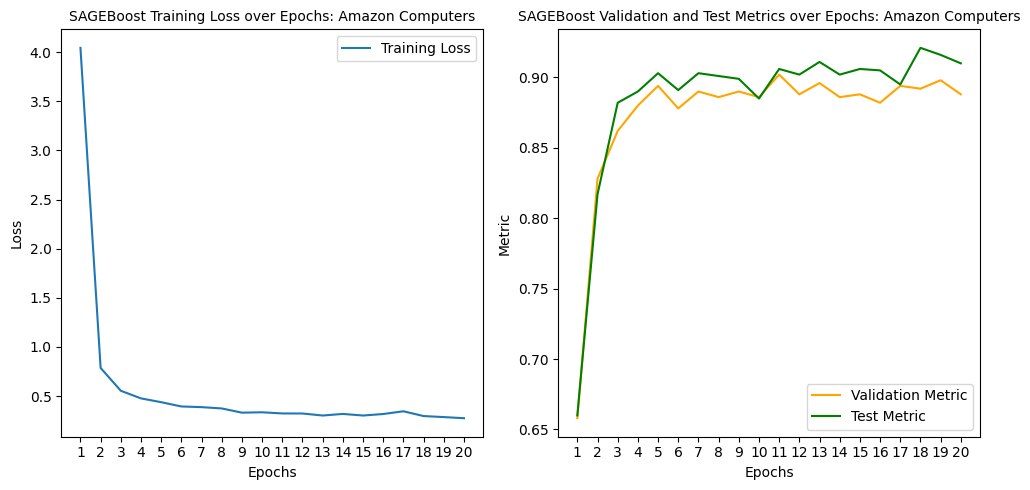

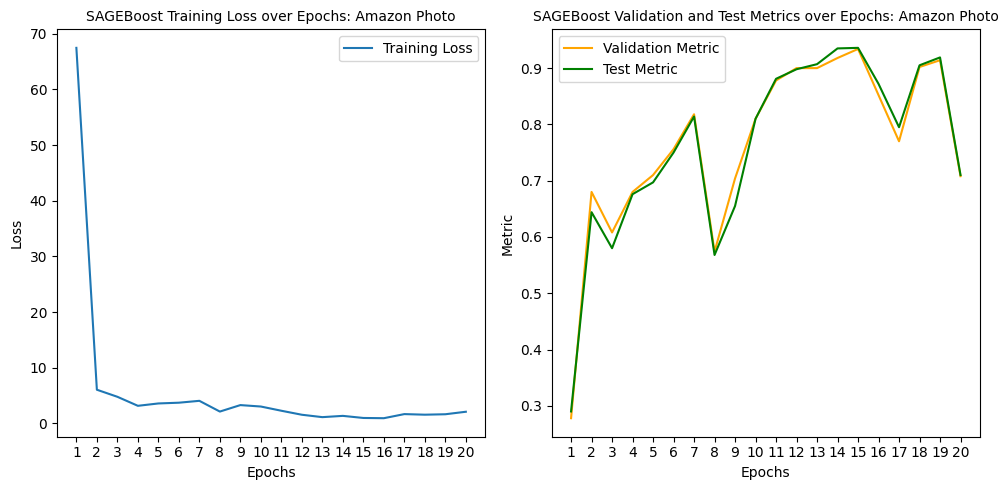

In [12]:
def plot_curves(curves, name):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('SAGEBoost Training Loss over Epochs: Amazon ' + name, fontsize = 10)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()


    # Plot validation and test metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, curves["valid"], label='Validation Metric', color='orange')
    plt.plot(epochs, curves["test"], label='Test Metric', color='green')
    plt.title('SAGEBoost Validation and Test Metrics over Epochs: Amazon ' + name, fontsize = 10)
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()


#print(train_curve2)
curves = {"train": train_curve, "valid": val_curve, "test": test_curve}
curves2 = {"train": train_curve2, "valid": val_curve2, "test": test_curve2}
plot_curves(curves, "Computers")
plot_curves(curves2, "Photo")


In [13]:
from numpy import ERR_DEFAULT
from torch.nn import ReLU
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)

        self.GCN1 = GCNConv(in_channels, hidden_channels)
        self.GCN2 = GCNConv(hidden_channels, out_channels)
        self.relu = ReLU()

        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)

        layer1 = self.GCN1(node_feature, edge_index)
        layer2 = self.relu(layer1)
        output = self.GCN2(layer2, edge_index)
        #########################################

        return output

In [22]:
def train(model, data, optimizer, loss_fn):

    loss = 0
    model.train()
    optimizer.zero_grad()

    y_pred = model(data.x, data.edge_index)

    loss = loss_fn(y_pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss

def calculate_accuracy(pred, label):
  highest_val = torch.argmax(pred, dim=1)
  correct = torch.where(highest_val==label, True, False)
  acc = torch.count_nonzero(correct)/len(correct)

  return acc


def test(model, data):

    accuracy_list = [0, 0, 0]
    model.eval()
    y_pred = model(data.x, data.edge_index).argmax(dim=1)

    accuracy_list[0]= (1/data.train_mask.sum()) * (y_pred[data.train_mask] == data.y[data.train_mask]).sum()
    accuracy_list[1]= (1/data.val_mask.sum()) * (y_pred[data.val_mask] == data.y[data.val_mask]).sum()
    accuracy_list[2]= (1/data.test_mask.sum()) * (y_pred[data.test_mask] == data.y[data.test_mask]).sum()

    return accuracy_list

In [24]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 256
num_features = dataset2.num_features
num_classes = dataset2.num_classes

model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = train(model, data2, optimizer, loss_fn)
    train_acc, val_acc, test_acc = test(model, data2)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))

after 20 epochs' training, the best test accuracy is 0.5670000314712524
